# experiments with `networkx`

_Alex Malz (CMU)_

## Basics of NetworkX

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

nodes can be objects (coordinates, images, etc.), and edges can be associated with objects

{200: {'object': {'overlap': 40}}, 300: {}}


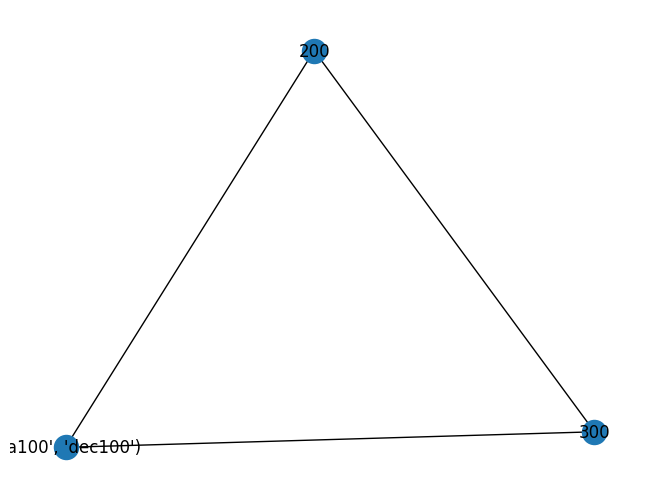

In [4]:
G = nx.Graph()
G.add_node(('ra100','dec100'))
G.add_nodes_from([200, 300])
G.add_edge(('ra100','dec100'), 200, object={'overlap': 40})

e1 = (200, 300)
e2 = (('ra100','dec100'), 300)
e = [e1, e2]

G.add_edges_from(e)  # unpack edge tuple*
print(G[('ra100','dec100')])
nx.draw(G, with_labels=True)

In [5]:
G.nodes

NodeView((('ra100', 'dec100'), 200, 300))

## IO with `networkx`

there are [many i/o formats](https://networkx.org/documentation/stable/reference/readwrite/index.html)!
we need to figure out what would be best for downstream consumers to parse. . .

In [6]:
nx.write_gpickle(G, 'test.pkl')

In [7]:
J = nx.read_gpickle('test.pkl')

In [8]:
J.adj

AdjacencyView({('ra100', 'dec100'): {200: {'object': {'overlap': 40}}, 300: {}}, 200: {('ra100', 'dec100'): {'object': {'overlap': 40}}, 300: {}}, 300: {200: {}, ('ra100', 'dec100'): {}}})

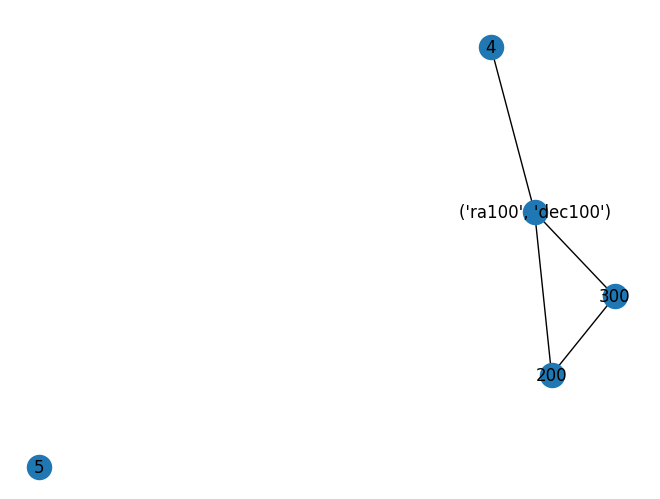

In [9]:
# add more nodes with attributes
G.add_nodes_from([
    (4, {"color": "red"}),

    (5, {"color": "green"}),

])
G.add_edge(('ra100','dec100'), 4, object={'overlap': 50})
nx.draw(G, with_labels=True)

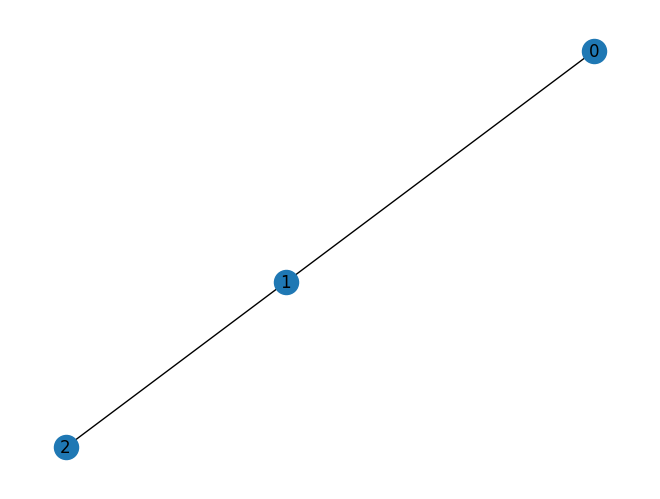

In [10]:
I = nx.Graph()
I.add_weighted_edges_from([(0, 1, 3.0), (1, 2, 7.5)])
#  Each edge given in the list or container will be added
#  |          to the graph. The edges must be given as 3-tuples (u, v, w)
nx.draw(I, with_labels=True)

In [11]:
# adjacency matrix includes the weights
I.adj

AdjacencyView({0: {1: {'weight': 3.0}}, 1: {0: {'weight': 3.0}, 2: {'weight': 7.5}}, 2: {1: {'weight': 7.5}}})

## Combining graphs

we can combine graphs representing postage stamps to make one for a whole catalog, and it will know the association between them

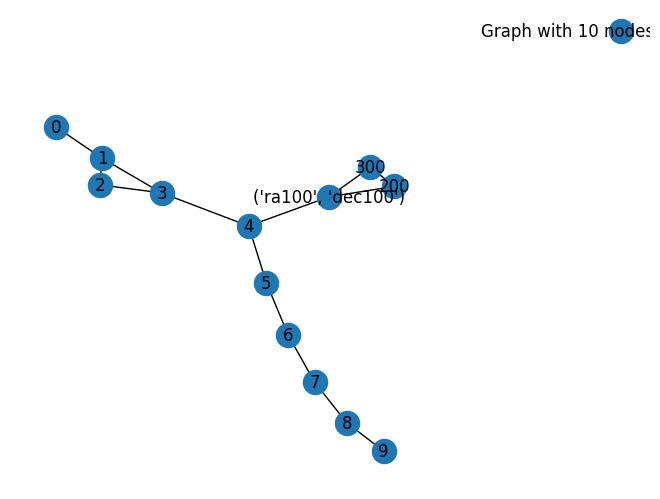

In [12]:
H = nx.path_graph(10)

G.add_nodes_from(H)
G.add_node(H)
G.add_edges_from([(1, 2), (1, 3)])
G.add_edges_from(H.edges)
nx.draw(G, with_labels=True)

In [13]:
G.degree()

DegreeView({('ra100', 'dec100'): 3, 200: 2, 300: 2, 4: 3, 5: 2, 0: 1, 1: 3, 2: 2, 3: 3, 6: 2, 7: 2, 8: 2, 9: 1, <networkx.classes.graph.Graph object at 0x12747c100>: 0})

## Bipartite structure in NetworkX

The real question is whether we benefit from bipartite structure...

## Basics of bipartite graphs

In [14]:
from networkx.algorithms import bipartite

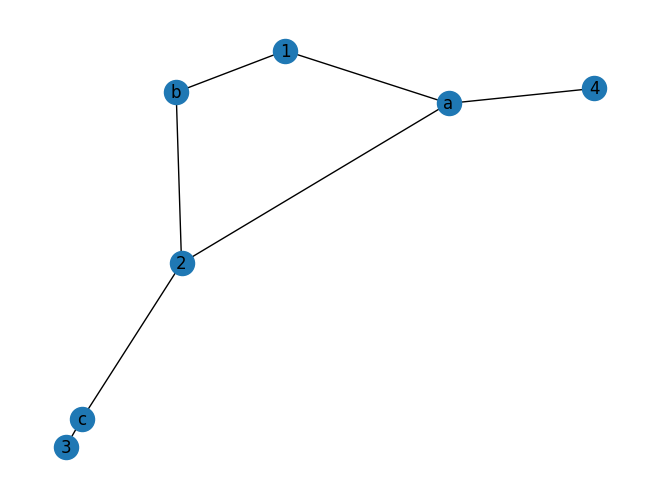

In [15]:
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
# (there is not a separate bipartite graph class)
B.add_nodes_from([1, 2, 3, 4], bipartite=0)

B.add_nodes_from(["a", "b", "c"], bipartite=1)

# Add edges only between nodes of opposite node sets

B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (2, "a"), (3, "c"), (4, "a")])
B[1]['a']['weight'] = 4
B[1]['b']['weight'] = 9
B[2]['b']['weight'] = 2
B[2]['c']['weight'] = 3
B[2]['a']['weight'] = 1
B[3]['c']['weight'] = 201
B[4]['a']['weight'] = 7
nx.draw(B, with_labels=True)

In [16]:
top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes
print(top_nodes, bottom_nodes)

{1, 2, 3, 4} {'a', 'b', 'c'}


In [17]:
# can confirm whether it's bipartite
assert bipartite.is_bipartite(B)

# check it works as expected
B.add_edge(1,2)
assert not bipartite.is_bipartite(B)
B.remove_edge(1,2)

In [19]:
# get each set of bipartite nodes
bipartite.sets(B)

({1, 2, 3, 4}, {'a', 'b', 'c'})

In [21]:
# or get dictionary where each key is a node and color is bipartite group it belongs to.
bipartite.color(B)

{1: 1, 'a': 0, 'b': 0, 2: 1, 'c': 0, 3: 1, 4: 1}

In [22]:
# Returns the degrees of the two node sets in the bipartite graph B.
bipartite.degrees(B, top_nodes, )

(DegreeView({'a': 3, 'b': 2, 'c': 2}), DegreeView({1: 2, 2: 3, 3: 1, 4: 1}))

In [26]:
B.edges.data('weight')

EdgeDataView([(1, 'a', 4), (1, 'b', 9), (2, 'b', 2), (2, 'c', 3), (2, 'a', 1), (3, 'c', 201), (4, 'a', 7)])

In [29]:
print(bipartite.biadjacency_matrix(B, row_order=top_nodes))

  (0, 0)	4
  (0, 1)	9
  (1, 0)	1
  (1, 1)	2
  (1, 2)	3
  (2, 2)	201
  (3, 0)	7


/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_3528/3255321828.py:1: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  print(bipartite.biadjacency_matrix(B, row_order=top_nodes))


## Functions on bipartite graphs

In [23]:
# density of graph
# intuition: the fraction of possible edges that exist in the graph
print(bipartite.density(B, top_nodes))
print(bipartite.density(B, bottom_nodes)) # should be the same

0.5833333333333334
0.5833333333333334


In [24]:
# matching
# a matching is a subset of edges in which no node occurs more than once

#just maximizes number of nodes matched (maximum cardinality matching)
print(bipartite.maximum_matching(B))

# maximizes the sum of the weights of the edges in the matching
print(bipartite.minimum_weight_full_matching(B))

{1: 'a', 2: 'b', 3: 'c', 'a': 1, 'b': 2, 'c': 3}
{1: 'b', 2: 'c', 4: 'a', 'b': 1, 'c': 2, 'a': 4}


/Users/imendoza/Library/Caches/pypoetry/virtualenvs/lost-and-found-FKw4AOAC-py3.9/lib/python3.9/site-packages/networkx/algorithms/bipartite/matching.py:569: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  weights_sparse = biadjacency_matrix(


In [25]:
# vertex cover
# a vertex cover is a subset of nodes such that every edge is incident to at least one node in the subset
print(bipartite.to_vertex_cover(B, bipartite.maximum_matching(B)))

{'a', 'b', 'c'}


In [28]:
# edge cover
# an edge cover is a subset of edges such that every node is incident to at least one edge in the subset
bipartite.min_edge_cover(B)

{('a', 1),
 ('a', 4),
 ('b', 2),
 ('c', 3),
 (1, 'a'),
 (2, 'b'),
 (3, 'c'),
 (4, 'a')}

In [75]:
# clustering
# for bipartite graphs is a measure of local density of connections (unweighted)
bipartite.clustering(B)

{1: 0.5833333333333333,
 2: 0.4444444444444444,
 3: 0.3333333333333333,
 4: 0.41666666666666663,
 'a': 0.4583333333333333,
 'b': 0.5,
 'c': 0.29166666666666663}

In [79]:
# redundancy
# The redundancy coefficient of a node v is the fraction of pairs of neighbors of v that are both linked to other nodes. In a one-mode projection these nodes would be linked together even if v were not there.
bipartite.node_redundancy(B, [1])

{1: 1.0}

In [80]:
# projections
# a projection of a bipartite graph is the graph that results from collapsing one of the node sets into a single node
# useful for summarizing bipartite graphs
# wikipedia: https://en.wikipedia.org/wiki/Bipartite_network_projection
# doesn't seem too useful for us 

EdgeDataView([(1, 'a', 4), (1, 'b', 9), (2, 'b', 2), (2, 'c', 3), (2, 'a', 1), (3, 'c', 201), (4, 'a', 7)])

In [30]:
# spectral bipartivity
# a measure of how bipartite a graph is
# not as useful for us either